# Bus Simulator Sandbox
## Yuwen Chang

In [3]:
# import packages
from __future__ import print_function, division
from IPython.display import display, clear_output

import os
import sys
import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import time
import calendar
from datetime import datetime

import collections
from collections import defaultdict

try:
    import urllib2 as urllib
except ImportError:
    import urllib.request as urllib

%pylab inline

Populating the interactive namespace from numpy and matplotlib


/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['datetime']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


# I. Data Generation Pipeline
## 1. Vehicle Data
## 1a. Real-time Data Query

In [4]:
from fetchbus import flatten, bus_data, plot_tsd

In [25]:
MTAAPI = os.getenv("MTAAPIKEY")
len(MTAAPI)

TypeError: object of type 'NoneType' has no len()

In [26]:
try:
    # for local running
    MTAAPI = os.getenv("MTAAPIKEY")
    len(MTAAPI)
except:
    # for ADRF running only
    from APIs import MTAAPI
    MTAAPI = MTAAPI()

In [11]:
# !python fetchbus.py $MTAAPIKEY "M1" 240
df = bus_data(MTAAPI, "M1", 1)


Time Elapsed: 0.0 min(s)
Bus Line: M1
Number of Active Buses: 21
Bus 1 (#MTA NYCT_6772) is at latitude 40.796502 and longitude -73.949494
Bus 2 (#MTA NYCT_6773) is at latitude 40.78825 and longitude -73.955518
Bus 3 (#MTA NYCT_6776) is at latitude 40.821105 and longitude -73.935743
Bus 4 (#MTA NYCT_3831) is at latitude 40.7364 and longitude -73.989146
Bus 5 (#MTA NYCT_6752) is at latitude 40.738451 and longitude -73.987629
Bus 6 (#MTA NYCT_3830) is at latitude 40.774703 and longitude -73.963306
Bus 7 (#MTA NYCT_3898) is at latitude 40.760833 and longitude -73.973423
Bus 8 (#MTA NYCT_6759) is at latitude 40.724513 and longitude -73.995794
Bus 9 (#MTA NYCT_6765) is at latitude 40.743464 and longitude -73.986091
Bus 10 (#MTA NYCT_6766) is at latitude 40.82093 and longitude -73.93587
Bus 11 (#MTA NYCT_6782) is at latitude 40.751852 and longitude -73.982074
Bus 12 (#MTA NYCT_3833) is at latitude 40.772905 and longitude -73.964615
Bus 13 (#MTA NYCT_3881) is at latitude 40.796083 and longitu

## 1b. Historical Sample Data

In [5]:
df = pd.read_csv("MTA_data/M1-Tue-180410-154415-260.csv")
df = df[df['DirectionRef'] == 1]
df['VehDistAlongRoute'] = df['CallDistanceAlongRoute'] - df['DistanceFromCall']
df['RecordedAtTime'] = pd.to_datetime(df['RecordedAtTime'])

# this bloc generate a sequence for psuedo real-time simulation
mod = list(df['Unnamed: 0'])
tiempo = 0
ts = []
for i,v in enumerate(mod[:-1]):
    ts.append(tiempo)
    if mod[i+1] < mod[i]:
        tiempo += 30
    else:
        continue
ts.append(ts[-1])
df['ts'] = ts

df.head()

,Unnamed: 0,Bearing,BlockRef,CallDistanceAlongRoute,DataFrameRef,DatedVehicleJourneyRef,DestinationName,DestinationRef,DirectionRef,DistanceFromCall,...,ProgressStatus,PublishedLineName,RecordedAtTime,StopPointName,StopPointRef,StopsFromCall,VehicleRef,VisitNumber,VehDistAlongRoute,ts
1,1,233.31764,MTA NYCT_OF_B8-Weekday-SDon_E_OF_52620_M7-205,7653.54,2018-04-10,MTA NYCT_OF_B8-Weekday-SDon-088000_M7_205,E VILLAGE 8 ST via 5 AV,MTA_403793,1,0.00,...,NaN,M1,2018-04-10 19:44:02,5 AV/W 59 ST,MTA_400512,0,MTA NYCT_6764,1,7653.54,0
2,2,49.23225,MTA NYCT_OF_B8-Weekday-SDon_E_OF_50340_M1-139,13730.36,2018-04-10,MTA NYCT_OF_B8-Weekday-SDon-084200_M1_139,GRAND STREET via 5 AV/BROADWAY,MTA_803192,1,6.76,...,layover,M1,2018-04-10 19:44:10,CENTRE ST/BROOME ST,MTA_803192,0,MTA NYCT_6748,1,13723.60,0
3,3,233.78738,MTA NYCT_OF_B8-Weekday-SDon_E_OF_55860_M1-149,1270.21,2018-04-10,MTA NYCT_OF_B8-Weekday-SDon-093400_M1_149,GRAND STREET via 5 AV/BROADWAY,MTA_803192,1,9.06,...,NaN,M1,2018-04-10 19:43:47,5 AV/W 135 ST,MTA_400094,0,MTA NYCT_6759,1,1261.15,0
4,4,234.06093,MTA NYCT_OF_B8-Weekday-SDon_E_OF_51900_M1-141,9963.37,2018-04-10,MTA NYCT_OF_B8-Weekday-SDon-086800_M1_141,GRAND STREET via 5 AV/BROADWAY,MTA_803192,1,14.94,...,NaN,M1,2018-04-10 19:43:45,5 AV/W 31 ST,MTA_400325,0,MTA NYCT_6773,1,9948.43,0
6,6,233.75938,MTA NYCT_OF_B8-Weekday-SDon_E_OF_29580_M1-123,4506.30,2018-04-10,MTA NYCT_OF_B8-Weekday-SDon-091900_M1_147,GRAND STREET via 5 AV/BROADWAY,MTA_803192,1,21.44,...,NaN,M1,2018-04-10 19:43:55,5 AV/EAST 98 ST,MTA_404081,0,MTA NYCT_6778,1,4484.86,0


In [6]:
df.columns

Index(['Unnamed: 0', 'Bearing', 'BlockRef', 'CallDistanceAlongRoute',
       'DataFrameRef', 'DatedVehicleJourneyRef', 'DestinationName',
       'DestinationRef', 'DirectionRef', 'DistanceFromCall',
       'ExpectedArrivalTime', 'ExpectedDepartureTime', 'JourneyPatternRef',
       'Latitude', 'LineRef', 'Longitude', 'Monitored', 'OperatorRef',
       'OriginAimedDepartureTime', 'OriginRef', 'PresentableDistance',
       'ProgressRate', 'ProgressStatus', 'PublishedLineName', 'RecordedAtTime',
       'StopPointName', 'StopPointRef', 'StopsFromCall', 'VehicleRef',
       'VisitNumber', 'VehDistAlongRoute', 'ts'],
      dtype='object')

## 2. Route Data
- METHOD 1: Subset and sort built-in data using CallDistanceAlongRoute in df
- METHOD 2: Query latest GTFS data through online database
- METHOD 3: Use up-to-date shapefile, read as gpd and query

## 2a. CallDistanceAlongRoute
Caveat: only available when there is at least one complete run in the data (can be combined by several buses)

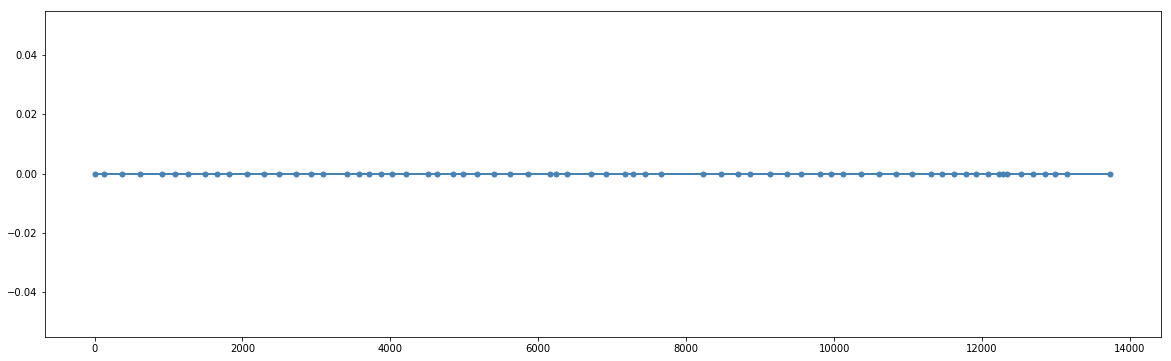

In [7]:
stops_x = df['CallDistanceAlongRoute'].unique()
stops_y = [0] * len(stops_x)

fig = plt.figure(figsize=(20,6))
ax = fig.add_subplot(111)
ax.plot(stops_x, stops_y, 'o-', color='steelblue', markersize=5)

## 2b. Query from GTFS Data
Caveat: multiple routes and shapes for a bus line

In [8]:
# import with py 2 and py 3 compatibility
try:
    import urllib2
    from urllib2 import HTTPError
    from urllib2 import urlopen
    from urllib import urlencode
    from StringIO import StringIO as io

except ImportError:
    import urllib
    from urllib.error import HTTPError
    from urllib.request import urlopen, Request
    from urllib.parse import urlencode
    from io import BytesIO as io

import ast

In [9]:
import fiona
import geopandas as gpd
from shapely.geometry import Point

In [10]:
# set SQL source
SQL_SOURCE = 'https://ywc249.carto.com/api/v2/sql?q='

# define query function
def queryCartoDB(query, format='CSV', source=SQL_SOURCE):
    """
    Queries carto datasets from a given carto account
    
    ARGUMENTS
    ----------
    query: a valid sql query string
    format: outlut format (default: CSV)
    source: a valid sql api endpoint OPTIONAL (default: Carto ywc249 account)

    RETURN
    ----------
    - the return of the sql query AS A STRING
    
    NOTES
    ----------
    designed for the carto API, tested only with CSV return format
    """
    
    data = urlencode({'format':format, 'q':query}).encode('utf-8')
    try:
        response = urlopen(source, data)
    except HTTPError as e:
        raise ValueError('\n'.join(ast.literal_eval(e.readline())['error']))
    except Exception:
        raise
    return response.read()

In [11]:
df['DatedVehicleJourneyRef'].unique()
df['DatedVehicleJourneyRef'].value_counts().idxmax()[9:]

'OF_B8-Weekday-SDon-095400_M1_154'

In [12]:
# make query for a given route
# the shape.txt files are pre-uploaded to my Carto space as csv files

route = df['PublishedLineName'].unique()[0]
boro = route[0].lower() # make query from respecttive GTFS shape csv
trip_id = df['DatedVehicleJourneyRef'].value_counts().idxmax()[9:]

q_shape = '''
SELECT *
FROM shapes_{0}
WHERE shape_id = (
  SELECT shape_id
  FROM trips_{0}
  WHERE trip_id = '{1}')
ORDER BY shape_pt_sequence
'''.format(boro, trip_id)

q_stop = '''
query stops shapefile here
'''

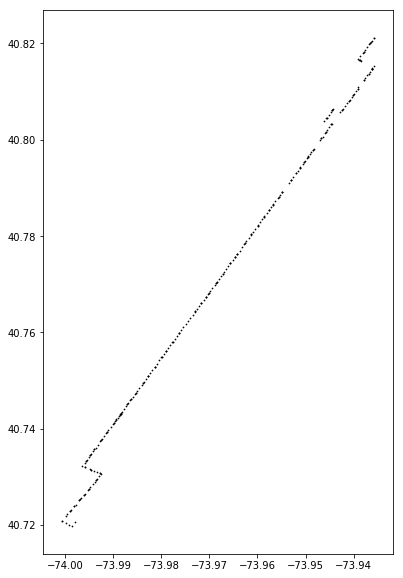

In [13]:
r_shape = pd.read_csv(io(queryCartoDB(q_shape)), sep=',')
r_shape['geometry'] = [Point(r_shape.iloc[i,5], r_shape.iloc[i,4]) for i in range(len(r_shape))]
shape_gdf = gpd.GeoDataFrame(r_shape)
shape_gdf.plot(facecolor='r', edgecolor='k', markersize=0.5, figsize=(10,10))

## 2c. Shapefile
Caveat: currently, I haven't found a good source that provides official or reliable constant update, but if there is one, this one is probably the easiest way

In [14]:
# read route shapefile
gdf = gpd.read_file("MTA_shp/bus_routes_nyc_aug2017.shp")
gdf.to_crs(epsg=4326, inplace=True)
gdf.head()

,route_id,dir_id,route_dir,route_shor,route_long,color,geometry
0,B11,0,B11_0,B11,Sunset Park - Midwood,006CB7,(LINESTRING (-74.00998100000001 40.64489999999...
1,B11,1,B11_1,B11,Sunset Park - Midwood,006CB7,"LINESTRING (-73.946749 40.63196099999984, -73...."
2,B12,0,B12_0,B12,Lefferts Gardens - East New York,6CBE45,(LINESTRING (-73.96175100000001 40.65492799999...
3,B12,1,B12_1,B12,Lefferts Gardens - East New York,6CBE45,"LINESTRING (-73.899996 40.67673899999983, -73...."
4,B13,0,B13_0,B13,Spring Creek - Wyckoff Hospital,FAA61A,"(LINESTRING (-73.876908 40.65273399999983, -73..."


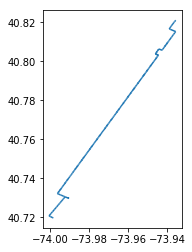

In [15]:
# specify line and direction query
lineref = 'M1'
direction = 1

# plot route
route_M1_1 = gdf[gdf['route_dir'] == '%s_%s'%(lineref, direction)]
route_M1_1.plot()

## 3. Visualization
## 3a. Time-space Diagram
Also include a log file!
## 3b. Plain Topology
## 3c. Plain Line

In [16]:
# import osmnx as ox
# import networkx as nx
# import geopandas as gpd
# from collections import Counter

# from geopy import Nominatim
# from geopy.distance import vincenty
# from shapely.geometry import Point

KeyboardInterrupt: 

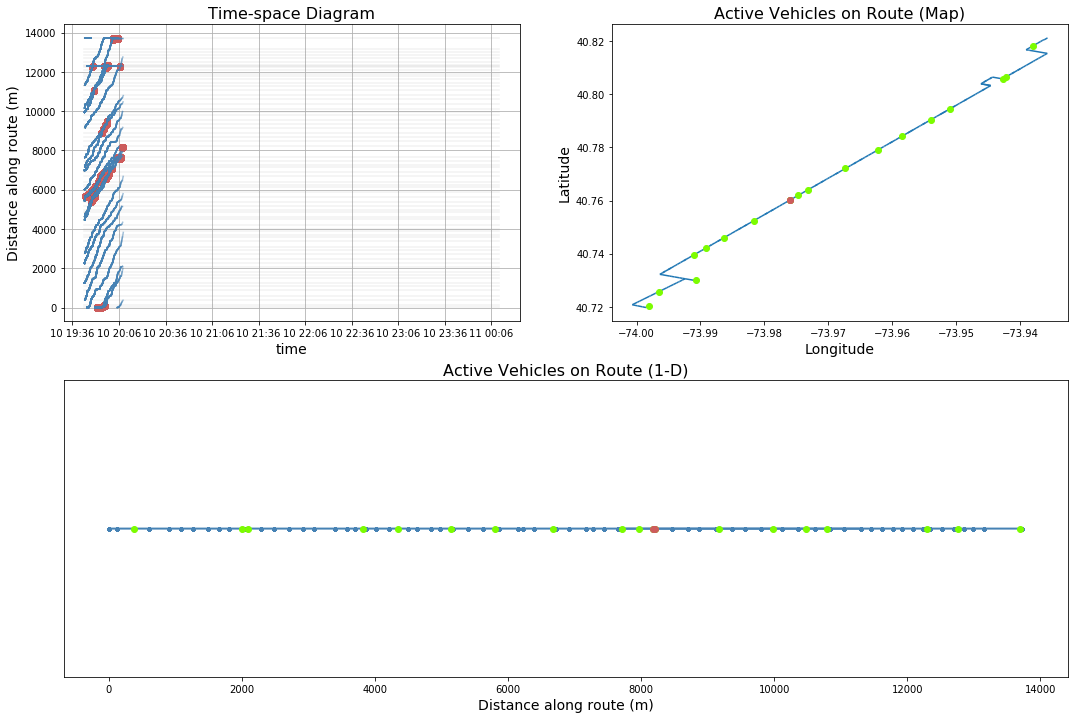

In [17]:
time_coef = 100

# plot figure
fig = plt.figure(figsize=(18,12))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(212)

# plot CallDistanceAlongRoute (bus stops)
[ax1.plot([df['RecordedAtTime'].min(), df['RecordedAtTime'].max()], [i, i], color='gray', alpha=0.1) for i in df['CallDistanceAlongRoute'].unique()]
p1, = ax1.plot([], [], '-', color='steelblue')

ax1.grid()
ax1.set_xlabel("time", fontsize=14)
ax1.set_ylabel("Distance along route (m)", fontsize=14)
ax1.set_title("Time-space Diagram", fontsize=16)

# plot route shape on map (2-D)
route_M1_1.plot(ax=ax2)
p7, = ax2.plot([], [], 'o', color='lawngreen')
p2, = ax2.plot([], [], 'o', color='indianred')

ax2.set_ylabel("Latitude", fontsize=14)
ax2.set_xlabel("Longitude", fontsize=14)
ax2.set_title("Active Vehicles on Route (Map)", fontsize=16)

# plot dynamic route line (1-D)
ax3.plot(df['CallDistanceAlongRoute'], [0]*len(df), '.-', color='steelblue')
p3, = ax3.plot([], [], 'o', color='lawngreen')
p4, = ax3.plot([], [], 'o', color='indianred')

ax3.set_yticks([])
ax3.set_xlabel("Distance along route (m)", fontsize=14)
ax3.set_title("Active Vehicles on Route (1-D)", fontsize=16)

# update
for i in range(0,df['ts'].max(),30):

    df3 = df[df['ts'] == i]
    df1 = df[df['ts'] <= i]
    
    # mark vehicles that are bunching 
    df3.sort_values(['VehDistAlongRoute'], inplace=True)
    spacing = np.diff(df3['VehDistAlongRoute'])
    bunch = spacing < 100 # set threshold (meters) to be identified as BB
    bunch_a = np.array([False] + list(bunch))
    bunch_b = np.array(list(bunch) + [False])
    bunch = bunch_a + bunch_b
    bb_df = df3[bunch]
    
    # plot TSD for each vehicle
    for i, v in enumerate(df1['VehicleRef'].unique()):
        # subset data for single vehicle
        veh_df = df1[df1['VehicleRef'] == v]
        ax1.plot(veh_df['RecordedAtTime'], veh_df['VehDistAlongRoute'], '-', color='steelblue', alpha=0.5)
        ax1.plot(bb_df['RecordedAtTime'], bb_df['VehDistAlongRoute'], 'o', color='indianred', alpha=0.5)
        #ax1.annotate('%s'%v.split("_")[1], (list(veh_df['RecordedAtTime'])[0],list(veh_df['VehDistAlongRoute'])[0]))

    p7.set_data(df3['Longitude'], df3['Latitude'])
    p2.set_data(bb_df['Longitude'], bb_df['Latitude'])
    p3.set_data(df3['VehDistAlongRoute'], [0]*len(df3))
    p4.set_data(bb_df['VehDistAlongRoute'], [0]*len(bb_df))
    clear_output(wait=True)
    display(fig)
    time.sleep(1/time_coef)
    
plt.tight_layout()
plt.show()

In [18]:
try:
    import urllib2 as urllib
except ImportError:
    import urllib.request as urllib
    
from fetchbus import flatten

In [19]:
def realtime(apikey, route, df):
    
    url = "http://bustime.mta.info/api/siri/vehicle-monitoring.json?key=%s&VehicleMonitoringDetailLevel=calls&LineRef=%s"%(apikey, route)
    
    # fetch data through MTA API
    response = urllib.urlopen(url)
    data = response.read().decode("utf-8")
    data = json.loads(data)

    # check if bus route exists
    try:
        data2 = data['Siri']['ServiceDelivery']['VehicleMonitoringDelivery'][0]['VehicleActivity']
    # print error if bus route not found
    except:
        error = data['Siri']['ServiceDelivery']['VehicleMonitoringDelivery'][0]['ErrorCondition']
        print(error['Description'])

    # print info of the current query request

#     print("Bus Line: " + route)
#     print("Number of Active Buses: " + str(len(data2)))

    # parse the data of each active vehicle
    for i, v in enumerate(data2):
        #if 'OnwardCall' in v['MonitoredVehicleJourney']['OnwardCalls']:
        try:
            # map variables
            dict1 = flatten(v['MonitoredVehicleJourney'])
            dict1['RecordedAtTime'] = v['RecordedAtTime']
            #dict1['SituationSimpleRef'] = dict1['SituationRef'][0]['SituationSimpleRef']
            dict1.pop('SituationRef')
            dict1.pop('OnwardCall')

            # print info of the vehicle
#             print("Bus %s (#%s) is at latitude %s and longitude %s"%(i+1, dict1['VehicleRef'], dict1['Latitude'], dict1['Longitude']))

            # write data to dictionary
            df_new = pd.DataFrame(dict1, index=[i])
            df = pd.concat([df, df_new])

        except Exception as e:
            print("Error: %s"%(e))
            pass
            
    df.to_csv("realtime.csv")
    return df, df_new

In [20]:
def df_process(df, direction):
    df = df[df['DirectionRef'] == direction]
    df['VehDistAlongRoute'] = df['CallDistanceAlongRoute'] - df['DistanceFromCall']
    df['RecordedAtTime'] = pd.to_datetime(df['RecordedAtTime'])
    return df

In [21]:
def df_update(apikey, route, direction):
    """ Append new data to existing csv file and return both all and new dfs"""
    try:
        df = pd.read_csv("realtime.csv")
    except:
        print("realtime.csv not found, creating new empty df")
        df = pd.DataFrame()
    df, df_new = realtime(apikey, route, df)
    
    # process variables for plotting
    df = df_process(df, direction)
    df_new = df_process(df_new, direction)
    
    return df, df_new

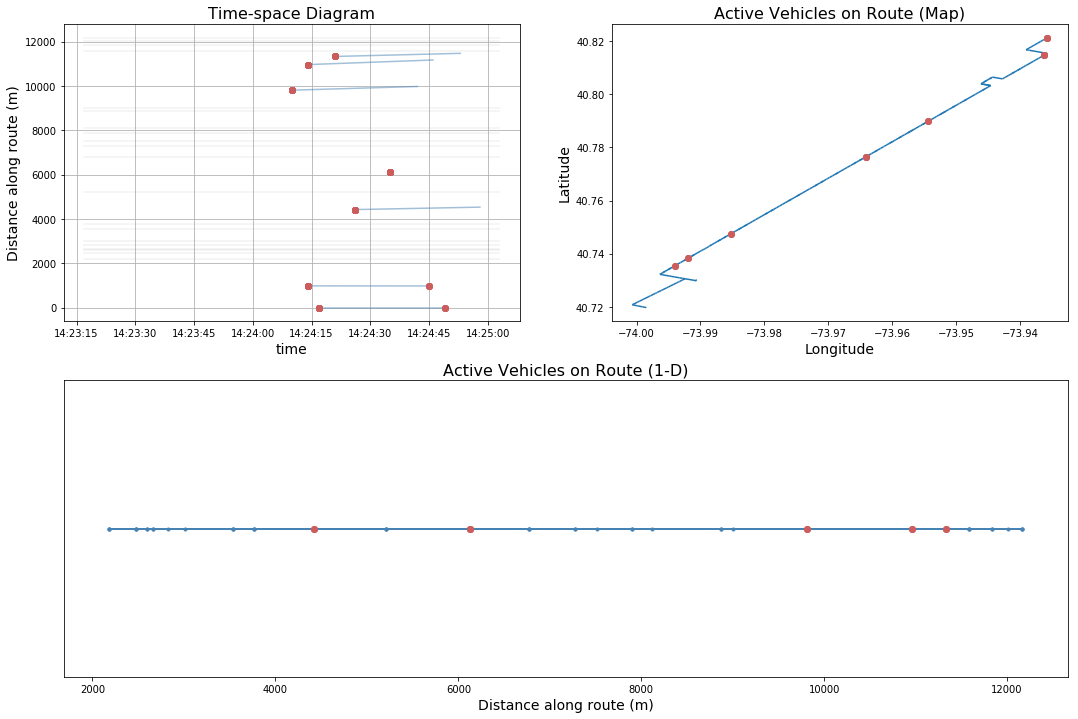

Seconds elapsed: 0


KeyboardInterrupt: 

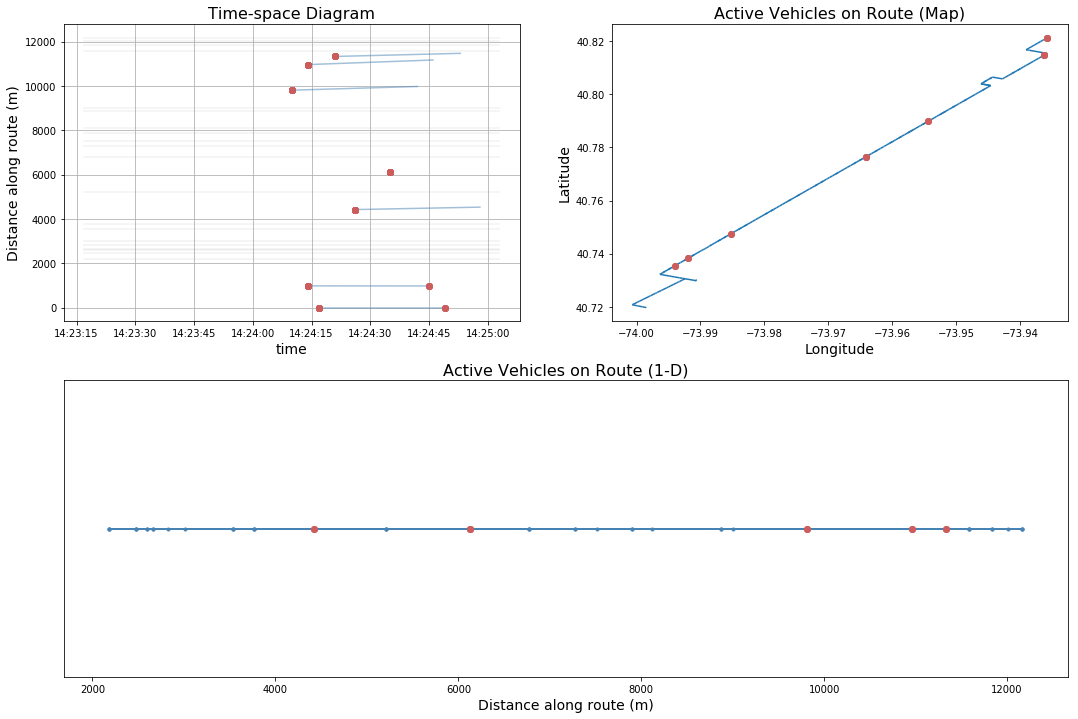

In [31]:
clock = 0
df, df_new = df_update(MTAAPI, "M1", 0)

# plot figure
fig = plt.figure(figsize=(18,12))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(212)

# plot CallDistanceAlongRoute (bus stops)
[ax1.plot([df['RecordedAtTime'].min(), df['RecordedAtTime'].max()], [i, i], color='gray', alpha=0.1) for i in df['CallDistanceAlongRoute'].unique()]
p1, = ax1.plot([], [], '-', color='steelblue')

ax1.grid()
ax1.set_xlabel("time", fontsize=14)
ax1.set_ylabel("Distance along route (m)", fontsize=14)
ax1.set_title("Time-space Diagram", fontsize=16)

# plot route shape on map (2-D)
route_M1_1.plot(ax=ax2)
p7, = ax2.plot([], [], 'o', color='lawngreen')
p2, = ax2.plot([], [], 'o', color='indianred')

ax2.set_ylabel("Latitude", fontsize=14)
ax2.set_xlabel("Longitude", fontsize=14)
ax2.set_title("Active Vehicles on Route (Map)", fontsize=16)

# plot dynamic route line (1-D)
ax3.plot(df['CallDistanceAlongRoute'], [0]*len(df), '.-', color='steelblue')
p3, = ax3.plot([], [], 'o', color='lawngreen')
p4, = ax3.plot([], [], 'o', color='indianred')

ax3.set_yticks([])
ax3.set_xlabel("Distance along route (m)", fontsize=14)
ax3.set_title("Active Vehicles on Route (1-D)", fontsize=16)

# update
while True:
    df1, df3 = df_update(MTAAPI, "M1", 1)
    
    # mark vehicles that are bunching
    try:
        df3.sort_values(['VehDistAlongRoute'], inplace=True)
        spacing = np.diff(df3['VehDistAlongRoute'])
        bunch = spacing < 100 # set threshold (meters) to be identified as BB
        bunch_a = np.array([False] + list(bunch))
        bunch_b = np.array(list(bunch) + [False])
        bunch = bunch_a + bunch_b
        bb_df = df3[bunch]
    except:
        pass
    
    # plot TSD for each vehicle
    for i, v in enumerate(df1['VehicleRef'].unique()):
        # subset data for single vehicle
        veh_df = df1[df1['VehicleRef'] == v]
        ax1.plot(veh_df['RecordedAtTime'], veh_df['VehDistAlongRoute'], '-', color='steelblue', alpha=0.5)
        ax1.plot(bb_df['RecordedAtTime'], bb_df['VehDistAlongRoute'], 'o', color='indianred', alpha=0.5)
        #ax1.annotate('%s'%v.split("_")[1], (list(veh_df['RecordedAtTime'])[0],list(veh_df['VehDistAlongRoute'])[0]))

    p7.set_data(df3['Longitude'], df3['Latitude'])
    p2.set_data(bb_df['Longitude'], bb_df['Latitude'])
    p3.set_data(df3['VehDistAlongRoute'], [0]*len(df3))
    p4.set_data(bb_df['VehDistAlongRoute'], [0]*len(bb_df))
    
    clear_output(wait=True)
    display(fig)
    print("Seconds elapsed: %s"%(clock))
    clock += 30
    time.sleep(30)
    
plt.tight_layout()
plt.show()

## 3d. Map Topology

In [45]:
import gmaps
gmaps.configure(api_key=os.getenv("GOOGLEAPIKEY"))

In [46]:
df_gmap = df[df['ts'] == 0]
location = list(zip(df_gmap['Latitude'], df_gmap['Longitude']))

In [47]:
fig = gmaps.figure()
fig.add_layer(gmaps.symbol_layer(location))
fig

Figure()

## 4. Simulation
## 4a. Objects Creation

## 4b. Attribute Assignment

## 4c. Environment Variables

## 4d. User Interface

## 4e. Dynamic Display
1. 0.5-sec update
2. time-space diagram
3. trace log

## 4f. Web Deployment
1. Control panel
2. Real-time info on Google basemap
3. Real-time info on straightened route topology
    - 3a. BB indicator
4. Dynamic time-space diagram

# End

- 3/11 4
- 3/12 1.5
- 3/16 1
- 3/17 2
- 3/18 2
- 3/20 1.5
- 3/23 2
- 4/3 3
- 4/5 0.5
- 4/6 1.5
- 4/9 1.5
- 4/21 9
- 4/22 9
- 4/23 1
- 4/24 1.5

In [46]:
# calculate stop distances
dist = []
lats = list(B54_merge['stop_lat'])
lons = list(B54_merge['stop_lon'])
for i in arange(len(B54_stops)):
    if i < len(B54_stops) - 1:
        p1 = lats[i], lons[i]
        p2 = lats[i+1], lons[i+1]
        di = vincenty(p1, p2).meters
        dist.append(di)
dist

[164.10592592573394,
 524.6821220855292,
 183.2864635647531,
 166.04481363027242,
 168.16662072005468,
 249.32389728515443,
 280.8678932398275,
 65.1613773786362,
 162.277246106055,
 160.8227222138864,
 156.99423276306914,
 177.8182272706027,
 262.3958689692586,
 186.7201549309188,
 134.44950499065496,
 113.44836241741916,
 271.7303956584878,
 243.00538513176005,
 292.5054493596941,
 190.84614888127206,
 295.74318979161654,
 180.16350288585392,
 297.9947729558094,
 205.45446314960742,
 168.5189134674809,
 151.1404164049675,
 170.5531370778554,
 218.34221496184352,
 226.21779839123397,
 226.0960471262775,
 374.39793393469455,
 130.71672370770722]

In [51]:
# calculate stop distances along the route (cumulative distance)
di = 0
cum_dist = [0]
for d in dist[:-1]:
    di += d
    cum_dist.append(di)
cum_dist = np.array(cum_dist)
cum_dist

array([   0.        ,  164.10592593,  688.78804801,  872.07451158,
       1038.11932521, 1206.28594593, 1455.60984321, 1736.47773645,
       1801.63911383, 1963.91635994, 2124.73908215, 2281.73331491,
       2459.55154218, 2721.94741115, 2908.66756608, 3043.11707107,
       3156.56543349, 3428.29582915, 3671.30121428, 3963.80666364,
       4154.65281252, 4450.39600231, 4630.5595052 , 4928.55427816,
       5134.00874131, 5302.52765477, 5453.66807118, 5624.22120826,
       5842.56342322, 6068.78122161, 6294.87726874, 6669.27520267])

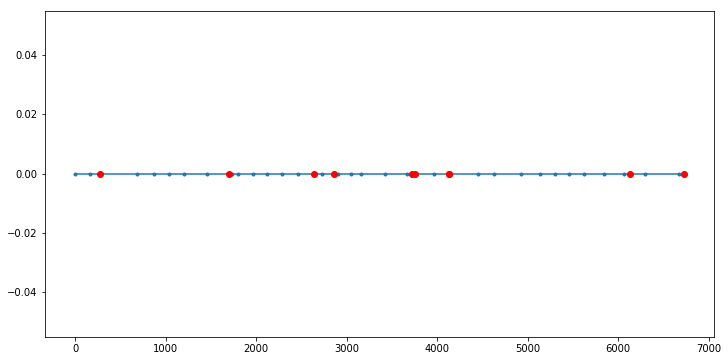

In [63]:
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(111)
ax.plot(cum_dist, [0]*len(cum_dist), '.-')
ax.plot(df['VehDistAlongRoute'], [0]*len(df), 'ro')
plt.show()

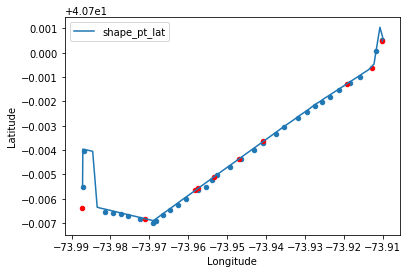

In [64]:
# plot route
ax = temp_shp.plot('shape_pt_lon', 'shape_pt_lat')

# plot stops
B54_stops.plot.scatter('stop_lon', 'stop_lat', ax=ax)

# plot active buses
df.plot.scatter('Longitude', 'Latitude', color='red', ax=ax)